In [44]:
__author__ = 'Chien-Hsiu Lee <lee@noao.edu>, Thomas Matheson <matheson@noao.edu>'
__version__ = '20200114' # yyyymmdd
__datasets__ = ['']
__keywords__ = ['ANTARES', 'variable']

# Exploring Elastic Search Database to Find R Corona Borealis Stars

*Chien-Hsiu Lee, Thomas Matheson & ANTARES Team*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)
* [First chapter](#chapter1)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals
This notebook is an example of how to explore the ANTARES alert database for variable stars. Here we use the infrared color selection of candidate R Coronae Borealise stars, and search the ZTF time-series photometry to see if there are unknown R CrBs revealing themselves by a significant, irregular dimming (up to 8 mag).

# Summary
We first obtain the candidate R CrBs from WISE color, selected by Tisserand et al. (2012). We then use the ANTARES search API to find time-series photometry of each candidate, and looked for R CrBs candidates that show more than 2 magnitude variability in either g- or r-band. In the end, we use ZTF18abhjrcf as a showcase.

<img src="RCB.jpeg">

# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noao.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup

In [45]:
from antares import dev_kit as dk
import matplotlib.pyplot as plt
import pandas as pd

<a class="anchor" id="import"></a>
# Read in relevant tables

We use the candidate list from Tisserand (2012), dropping candidates below Dec<-30 (in the ZTF field). Here we read in the list of candidate, specifically their ra and dec.

In [46]:
catalog=pd.read_csv('WISE_RCrB.dat')
ra=catalog['ra']
dec=catalog['dec']

<a class="anchor" id="import"></a>
# Querying ANTARES alert database 

This cell shows how to call elastic search with ANTARES API. It can search on ZTF object id, RA, Dec, or other properties. For our purpose, we search for variabilities larger than 2 mag in either g- or r-band. For illustration purpose, we only search variability in three of the candidate (id = 228-230)

In [47]:
from antares_client.search import search
#for i in range(len(ra)): #this line will search for the full candidate list for variability
for i in [228, 229, 230]:  
    print("Iteration: ",i, "ra",ra[i],"dec",dec[i])
    query = {
        "query": {
            "bool": {
                "must": [
                    {
                        "range": {
                            "ra": {
                                "gte": ra[i]-1./3600.,
                                "lte": ra[i]+1./3600.,
                            }
                        }
                    },
                    {
                        "range": {
                            "dec": {
                                "gte": dec[i]-1./3600.,
                                "lte": dec[i]+1./3600.
                            }
                        }
                    }
                 ]
            }
        }
    }
    result_set = search(query)    
    galerts = [
        alert
        for alert in result_set
        if (
            alert["survey"] == 1
            and len(alert["properties"])
            and alert["properties"]["ztf_fid"] == "1"
            )
    ]
    gmag = [float(alert["properties"]["ztf_magpsf"]) for alert in galerts]
    ralerts = [
        alert
        for alert in result_set
        if (
            alert["survey"] == 1
            and len(alert["properties"])
            and alert["properties"]["ztf_fid"] == "2"
            )
    ]
    rmag = [float(alert["properties"]["ztf_magpsf"]) for alert in ralerts]       
    if len(gmag)>1 and max(gmag)-min(gmag) > 2.: 
        print("Got a hit on locus_id: ",result_set[0]["locus_id"]," in g-band")
    if len(rmag)>1 and max(rmag)-min(rmag) > 2.:
        print("Got a hit on locus_id: ",result_set[0]["locus_id"]," in r-band")
        
        

Iteration:  228 ra 275.832794 dec -14.109205
Iteration:  229 ra 283.318207 dec -27.231319
Got a hit on locus_id:  231020  in r-band
Iteration:  230 ra 280.69277900000003 dec -12.904075
Got a hit on locus_id:  425493  in g-band


<a class="anchor" id="import"></a>
# Extracting light curve related properties



Looks like we got a hit. Let's have a look at the last one (locus_id 425493). We first extract relevant properties (MJD, Mag, Mag_err) from this locus.

In [48]:
galerts = [
    alert
    for alert in result_set
    if (
        alert["survey"] == 1
        and len(alert["properties"])
        and alert["properties"]["ztf_fid"] == "1"
    )
]
gdate = [float(alert["properties"]["ztf_jd"]) for alert in galerts]
gmag = [float(alert["properties"]["ztf_magpsf"]) for alert in galerts]
gerr = [float(alert["properties"]["ztf_sigmapsf"]) for alert in galerts]

ralerts = [
    alert
    for alert in result_set
    if (
        alert["survey"] == 1
        and len(alert["properties"])
        and alert["properties"]["ztf_fid"] == "2"
    )
]
rdate = [float(alert["properties"]["ztf_jd"]) for alert in ralerts]
rmag = [float(alert["properties"]["ztf_magpsf"]) for alert in ralerts]
rerr = [float(alert["properties"]["ztf_sigmapsf"]) for alert in ralerts]



Having the time-series photometry in hand, we can plot the light curve.

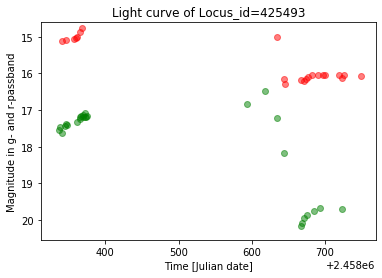

In [49]:
plt.ylim(max(gmag)+0.1*(max(gmag)-min(gmag)),min(rmag)-0.1*(max(rmag)-min(rmag)))
plt.scatter(rdate, rmag, c='red', alpha=0.5)
plt.scatter(gdate, gmag, c='green', alpha=0.5)
plt.title('Light curve of Locus_id=425493')
plt.xlabel('Time [Julian date]')
plt.ylabel('Magnitude in g- and r-passband')
plt.show()

# Concluding remarks

Locus_id 425493 (=ZTF18abhjrcf) shows a rapid dropping of more than 2 magnitudes in g-band, and consistent dimming in the r-band as well (thought not as much as g-band). This is similar to the sudden dimming seen in R Coronae Borealis. We subsequently obtained spectra of this source, and confirmed its RCB nature.

# Resources and references
Further reading:

AAVSO introduction on R Coronae Borealis stars: https://www.aavso.org/vsots_rcrb

Tisserand (2012) "Tracking down R Coronae Borealis stars from their mid-infrared WISE colours". A&A, 539, 51: https://ui.adsabs.harvard.edu/abs/2012A&A...539A..51T

Tisserand et al. (2013) "The ongoing pursuit of R Coronae Borealis stars: the ASAS-3 survey strikes again". A&A, 551, 22: https://ui.adsabs.harvard.edu/abs/2013A&A...551A..77T